In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math

importing dataset

In [2]:
d_train = pd.read_csv("Polynomialdata_train.csv")
d_test = pd.read_csv("Polynomialdata_test.csv")

In [3]:
X_test_g = d_test[d_test.columns.values]
X_test_g = X_test_g.drop(['ID'], axis=1)
X_test_g = X_test_g.to_numpy()

In [4]:
X = d_train[['feature 1', 'feature 2', 'feature 3']]
Y = d_train[['target']]

In [5]:
x_features = ['feature 1', 'feature 2', 'feature 3']

In [6]:
print(f"x Shape: {X.shape}, X Type:{type(X)}")
print(f"y Shape: {Y.shape}, y Type:{type(Y)}")

x Shape: (50000, 3), X Type:<class 'pandas.core.frame.DataFrame'>
y Shape: (50000, 1), y Type:<class 'pandas.core.frame.DataFrame'>


In [7]:
X = X.to_numpy().reshape(50000,3)
Y = Y.to_numpy().reshape(50000)

feature scaling

In [9]:
def zscore_normalize_features(x):
  mu = np.mean(x, axis=0)             
  sigma  = np.std(x, axis=0)                  
  x_norm = (x - mu) / sigma      
  return (x_norm, mu, sigma)

In [10]:
# normalize the original features
x_norm, x_mu, x_sigma = zscore_normalize_features(X)
print(f"X_mu = {x_mu}, \nX_sigma = {x_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(x_norm,axis=0)}")

X_mu = [ 0.09996351  0.01256211 -0.20509985], 
X_sigma = [21.84180997  4.00048729 56.04534679]
Peak to Peak range by column in Raw        X:[194.81818672  34.88386435 484.02938964]
Peak to Peak range by column in Normalized X:[8.91950745 8.7199038  8.63638852]


In [11]:
x_norm_test, x_mu_test, x_sigma_test = zscore_normalize_features(X_test_g)

In [12]:
X_test_g = x_norm_test

In [41]:
X = x_norm

Plot of features vs labels

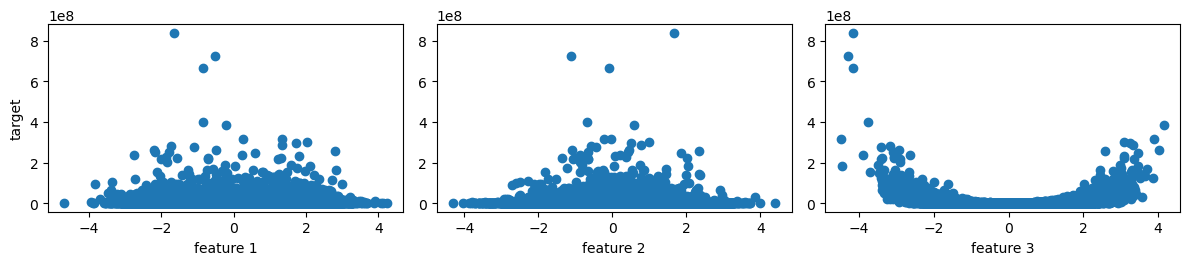

In [42]:
fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X[:,0], Y)
ax[0].set_xlabel(x_features[0]); ax[0].set_ylabel('target')

ax[1].scatter(X[:,1], Y)
ax[1].set_xlabel(x_features[1]); ax[0].set_ylabel('target')

ax[2].scatter(X[:,2], Y)
ax[2].set_xlabel(x_features[2]); ax[0].set_ylabel('target')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

splitting the dataset

In [14]:
x_train = X[:30000,]
y_train = Y[:30000,]
x_cv = X[30000:40000,]
y_cv = Y[30000:40000,]
x_test = X[40000:,]
y_test = Y[40000:,]

Training the data

In [15]:
def prediction(x, w, b):
    y_pred = np.matmul(x,w) + b
    return y_pred

In [16]:
def compute_cost(x, y, w, b, lambda_):
    m = x.shape[0]
    y_pred = prediction(x, w, b)
    err = y_pred - y
    j = np.matmul(np.transpose(err),err)/(2*m)
    reguralization = np.matmul(np.transpose(w),w)*lambda_/(2*m)
    j_reguralized = j + reguralization
    return j_reguralized

In [17]:
def gradient(X, y, w, b):
    m = X.shape[0]
    dj_dw = 2*np.matmul(np.matmul(np.transpose(X), X), w) - 2*np.matmul(np.transpose(X), y) 
    y_pred = prediction(X, w, b)
    error = y_pred - y
    dj_db = sum(error)/m
    dj_dw = dj_dw/(m)
    return dj_dw, dj_db

In [18]:
def gradient_descent(x, y, w, b, alpha, max_iters, lambda_):
    m = x.shape[0]
    J_history = []
    w_curr = copy.deepcopy(w)
    b_curr = b
    cost_curr = compute_cost(x, y, w_curr, b_curr, lambda_)
    iter_curr = 0
    while iter_curr < max_iters and cost_curr >= 0.000000001:
        dj_dw, dj_db = gradient(x, y, w_curr, b_curr)
        w_curr = (w_curr - alpha * dj_dw) + w_curr*lambda_/m
        b_curr = (b_curr - alpha * dj_db) 
        cost_curr = compute_cost(x, y, w_curr, b_curr, lambda_)
        J_history.append(cost_curr)
        if iter_curr%1000 == 0:
            print(f"Iteration:{iter_curr} Current_cost: {cost_curr}")
        iter_curr += 1
    return w_curr, b_curr, J_history, iter_curr

In [19]:
def multinomial_features(x, n):
    m = x.shape[0]
    terms = math.comb(n + 2, 2)
    features = np.zeros((m, terms))
    for i in range(m):
        x1, x2, x3 = x[i]
        terms = [x1**m1 * x2**m2 * x3**m3 for m1 in range(n + 1) for m2 in range(n + 1) for m3 in range(n + 1) if m1 + m2 + m3 == n]
        features[i] = terms
    return features


In [20]:
def degree_features():
#training data
    degree_train = {}
    degree_cv = {}
    degree_test = {}
    test_data = {}
    for i in range(1,8):
        degree_train[f'degree_train{i}'] = multinomial_features(x_train, i)
        degree_cv[f'degree_cv{i}'] = multinomial_features(x_cv, i)
        degree_test[f'degree_test{i}'] = multinomial_features(x_test, i)
        test_data[f'test_degree{i}'] = multinomial_features(X_test_g, i)
    return degree_train, degree_cv, degree_test, test_data


In [21]:
degree_train, degree_cv, degree_test, test_data = degree_features()

Degree 2

In [22]:
#degree 2
#Training data
X_train_2 = np.concatenate([degree_train[f'degree_train{2}'],degree_train[f'degree_train{1}']], axis=1)
print(f"x_train shape: {X_train_2.shape}")

b_initial_2 = 0.0000
w_initial_2 = np.zeros(shape=X_train_2.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_2, y_train, w_initial_2, b_initial_2, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.01
max_iters = 4000
w_final_2, b_final_2, Cost_history_2, num_iters = gradient_descent(X_train_2, y_train, w_initial_2, b_initial_2, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_2:0.2f}")
print(f"w_final: {w_final_2}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{2}'],degree_cv[f'degree_cv{1}']], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_2, b_final_2, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test data
X_test_2 = np.concatenate([degree_test[f'degree_test{2}'],degree_test[f'degree_test{1}']], axis=1)

x_train shape: (30000, 9)
J_train: 64011477841852.64
Iteration:0 Current_cost: 61427132355226.15
Iteration:1000 Current_cost: 38221652448821.8
Iteration:2000 Current_cost: 38221652445930.414
Iteration:3000 Current_cost: 38221652445930.414
b_final: -1340173.82
w_final: [3824953.63688694  785540.17282773 -669627.87975808 3272695.900334
  294593.47229628  -39620.92322749  -89405.52545349    8586.31945232
  -19671.62162002]
x_cv shape: (10000, 9)
J_cv: 28823261028842.125


Degree 3

In [23]:
#degree 3
#Training data
X_train_3 = np.concatenate([degree_train[f'degree_train{3}'],degree_train[f'degree_train{2}'], degree_train[f'degree_train{1}'] ], axis=1)
print(f"x_train shape: {X_train_3.shape}")

b_initial_3 = 0.0000
w_initial_3 = np.zeros(shape=X_train_3.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_3, y_train, w_initial_3, b_initial_3, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.01
max_iters = 9000
w_final_3, b_final_3, Cost_history_3, num_iters = gradient_descent(X_train_3, y_train, w_initial_3, b_initial_3, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_3:0.2f}")
print(f"w_final: {w_final_3}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{3}'],degree_cv[f'degree_cv{2}'], degree_cv[f'degree_cv{1}'] ], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_3, b_final_3, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test data
X_test_3 = np.concatenate([degree_test[f'degree_test{3}'],degree_test[f'degree_test{2}'], degree_test[f'degree_test{1}'] ], axis=1)

x_train shape: (30000, 19)
J_train: 64011477841852.64
Iteration:0 Current_cost: 61357892475620.625
Iteration:1000 Current_cost: 37944105885732.914
Iteration:2000 Current_cost: 37944106368250.74
Iteration:3000 Current_cost: 37944106378276.11
Iteration:4000 Current_cost: 37944106378322.02
Iteration:5000 Current_cost: 37944106378322.23
Iteration:6000 Current_cost: 37944106378322.24
Iteration:7000 Current_cost: 37944106378322.24
Iteration:8000 Current_cost: 37944106378322.24
b_final: -1339498.75
w_final: [-293599.4488146   -66138.37691851   57010.97194896   11016.27451013
 -130723.54642528  -13672.78542719   60442.50718881  -33870.92826623
   24058.3104709     4214.59289453 3827974.64766688  788066.77170888
 -669817.17812797 3271475.31729598  294473.3631326   -41040.58287646
  758495.49017993   17494.1623027    27350.08821007]
x_cv shape: (10000, 19)
J_cv: 27573728072009.883


Degree 4

In [24]:
#degree 4
#Training data
X_train_4 = np.concatenate([degree_train[f'degree_train{4}'] ,degree_train[f'degree_train{3}'],degree_train[f'degree_train{2}'], degree_train[f'degree_train{1}'] ], axis=1)
print(f"x_train shape: {X_train_4.shape}")

b_initial_4 = 0.0000
w_initial_4 = np.zeros(shape=X_train_4.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_4, y_train, w_initial_4, b_initial_4, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.001
max_iters = 10000
w_final_4, b_final_4, Cost_history_4, num_iters = gradient_descent(X_train_4, y_train, w_initial_4, b_initial_4, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_4:0.2f}")
print(f"w_final: {w_final_4}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{4}'] ,degree_cv[f'degree_cv{3}'],degree_cv[f'degree_cv{2}'], degree_cv[f'degree_cv{1}'] ], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_4, b_final_4, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test Data
X_test_4 = np.concatenate([degree_test[f'degree_test{4}'] ,degree_test[f'degree_test{3}'],degree_test[f'degree_test{2}'], degree_test[f'degree_test{1}'] ], axis=1)


x_train shape: (30000, 34)
J_train: 64011477841852.64
Iteration:0 Current_cost: 48057098462941.28
Iteration:1000 Current_cost: 5112039841070.836
Iteration:2000 Current_cost: 4359134102670.428
Iteration:3000 Current_cost: 4137740447097.0806
Iteration:4000 Current_cost: 4060292323930.9897
Iteration:5000 Current_cost: 4029117678847.57
Iteration:6000 Current_cost: 4015526402983.484
Iteration:7000 Current_cost: 4009355685427.2905
Iteration:8000 Current_cost: 4006483975456.578
Iteration:9000 Current_cost: 4005118785232.447
b_final: 344623.99
w_final: [ 1.30308829e+06  5.06573748e+05 -9.34885631e+04 -2.60849606e+04
 -4.51951101e+04  1.95768110e+06  5.33902012e+05  6.87903791e+02
  1.81033175e+03  9.34941745e+05  1.88596161e+05 -8.77571534e+04
  2.24885210e+05  4.05640311e+04 -2.19553218e+04 -1.47022378e+05
 -5.91100922e+04  2.71211224e+04  3.33510057e+03 -8.32112895e+04
  2.60240680e+04  2.61690292e+04  4.02303115e+04  2.12042622e+04
  5.07695909e+03 -3.73719220e+06 -8.72621638e+05  6.4029050

Degree 5

In [25]:
#degree 5
#Training data
X_train_5 = np.concatenate([degree_train[f'degree_train{5}'], degree_train[f'degree_train{4}'] ,degree_train[f'degree_train{3}'],degree_train[f'degree_train{2}'], degree_train[f'degree_train{1}'] ], axis=1)
print(f"x_train shape: {X_train_5.shape}")

b_initial_5 = 0.0000
w_initial_5 = np.zeros(shape=X_train_5.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_5, y_train, w_initial_5, b_initial_5, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.0001
max_iters = 10000
w_final_5, b_final_5, Cost_history_5, num_iters = gradient_descent(X_train_5, y_train, w_initial_5, b_initial_5, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_5:0.2f}")
print(f"w_final: {w_final_5}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{5}'], degree_cv[f'degree_cv{4}'] ,degree_cv[f'degree_cv{3}'],degree_cv[f'degree_cv{2}'], degree_cv[f'degree_cv{1}'] ], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_5, b_final_5, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test_data
X_test_5 = np.concatenate([degree_test[f'degree_test{5}'], degree_test[f'degree_test{4}'] ,degree_test[f'degree_test{3}'],degree_test[f'degree_test{2}'], degree_test[f'degree_test{1}'] ], axis=1)

x_train shape: (30000, 55)
J_train: 64011477841852.64
Iteration:0 Current_cost: 61888466767607.38
Iteration:1000 Current_cost: 8570948877132.344
Iteration:2000 Current_cost: 7138046934337.584
Iteration:3000 Current_cost: 6452656336947.181
Iteration:4000 Current_cost: 5987094142177.04
Iteration:5000 Current_cost: 5632443253758.812
Iteration:6000 Current_cost: 5349225518454.708
Iteration:7000 Current_cost: 5116712391665.651
Iteration:8000 Current_cost: 4922119455481.436
Iteration:9000 Current_cost: 4756955185593.556
b_final: -86990.85
w_final: [-6.35235733e+04 -3.73111975e+04  3.62983542e+04  1.33020169e+04
  2.16956503e+03  2.45859360e+03 -1.00795786e+05 -2.52923886e+04
  8.03783257e+04  3.28962065e+04 -6.07079847e+03  2.75533835e+04
  5.45387257e+04  7.29391374e+04  8.25840916e+03  5.97755930e+04
  2.50153630e+04 -4.15839487e+03 -8.84748540e+03  4.11189533e+03
 -2.52105268e+03  1.13091842e+06  4.44442580e+05 -1.98704760e+05
 -9.75917109e+04  2.20175375e+04  1.65769863e+06  4.92981316e+

Degree 6

In [26]:
#degree 6
#Training data
X_train_6 = np.concatenate([degree_train[f'degree_train{6}'], degree_train[f'degree_train{5}'], degree_train[f'degree_train{4}'] ,degree_train[f'degree_train{3}'],degree_train[f'degree_train{2}'], degree_train[f'degree_train{1}'] ], axis=1)
print(f"x_train shape: {X_train_6.shape}")

b_initial_6 = 0.0000
w_initial_6 = np.zeros(shape=X_train_6.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_6, y_train, w_initial_6, b_initial_6, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.00001
max_iters = 10000
w_final_6, b_final_6, Cost_history_6, num_iters = gradient_descent(X_train_6, y_train, w_initial_6, b_initial_6, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_6:0.2f}")
print(f"w_final: {w_final_6}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{6}'], degree_cv[f'degree_cv{5}'], degree_cv[f'degree_cv{4}'] ,degree_cv[f'degree_cv{3}'],degree_cv[f'degree_cv{2}'], degree_cv[f'degree_cv{1}'] ], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_6, b_final_6, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test Data
X_test_6 = np.concatenate([degree_test[f'degree_test{6}'], degree_test[f'degree_test{5}'], degree_test[f'degree_test{4}'] ,degree_test[f'degree_test{3}'],degree_test[f'degree_test{2}'], degree_test[f'degree_test{1}'] ], axis=1)

x_train shape: (30000, 83)
J_train: 64011477841852.64
Iteration:0 Current_cost: 46446565113853.81
Iteration:1000 Current_cost: 64596762061.04688
Iteration:2000 Current_cost: 15292683155.769482
Iteration:3000 Current_cost: 6510431178.611
Iteration:4000 Current_cost: 3918231853.1632915
Iteration:5000 Current_cost: 2703298653.5247984
Iteration:6000 Current_cost: 1974502536.974041
Iteration:7000 Current_cost: 1491819098.674462
Iteration:8000 Current_cost: 1157620882.5211287
Iteration:9000 Current_cost: 919768394.401031
b_final: -652.77
w_final: [ 7.94889395e+04  3.40578123e+04  5.82713048e+03  8.76521323e-01
 -1.51814861e+02  1.23994956e+01  3.46997953e+01  1.84761515e+05
  6.49585383e+04  8.70610802e+03  2.08001364e+03 -2.44193539e+02
 -1.76797009e+02  1.79041064e+05  4.64725614e+04  8.25692814e+03
  2.32400949e+03 -2.39810725e+02  9.14330630e+04  1.98128932e+04
  1.69674183e+03  6.79751376e+02  2.66730621e+04  4.93158871e+03
  1.02806654e+02  4.08373131e+03  2.56987127e+02  4.94940837e+0

Degree 7

In [27]:
#degree 7
#Training data
X_train_7 = np.concatenate([degree_train[f'degree_train{7}'], degree_train[f'degree_train{6}'], degree_train[f'degree_train{5}'], degree_train[f'degree_train{4}'] ,degree_train[f'degree_train{3}'],degree_train[f'degree_train{2}'], degree_train[f'degree_train{1}'] ], axis=1)
print(f"x_train shape: {X_train_7.shape}")

b_initial_7 = 0.0000
w_initial_7 = np.zeros(shape=X_train_7.shape[1])
lambda_tmp = 0.00

computed_cost_train = compute_cost(X_train_7, y_train, w_initial_7, b_initial_7, lambda_tmp)
print(f"J_train: {computed_cost_train}")

alpha = 0.000001
max_iters = 10000
w_final_7, b_final_7, Cost_history_7, num_iters = gradient_descent(X_train_7, y_train, w_initial_7, b_initial_7, alpha, max_iters, lambda_tmp)
print(f"b_final: {b_final_7:0.2f}")
print(f"w_final: {w_final_7}")

#Cross Validaton data
X_cv = np.concatenate([degree_cv[f'degree_cv{7}'], degree_cv[f'degree_cv{6}'], degree_cv[f'degree_cv{5}'], degree_cv[f'degree_cv{4}'] ,degree_cv[f'degree_cv{3}'],degree_cv[f'degree_cv{2}'], degree_cv[f'degree_cv{1}'] ], axis=1)
print(f"x_cv shape: {X_cv.shape}")

cost_cv = compute_cost(X_cv, y_cv, w_final_7, b_final_7, lambda_tmp)
print(f'J_cv: {cost_cv}')

#Test Data
X_test_7 = np.concatenate([degree_test[f'degree_test{7}'], degree_test[f'degree_test{6}'], degree_test[f'degree_test{5}'], degree_test[f'degree_test{4}'] ,degree_test[f'degree_test{3}'],degree_test[f'degree_test{2}'], degree_test[f'degree_test{1}'] ], axis=1)

x_train shape: (30000, 119)
J_train: 64011477841852.64
Iteration:0 Current_cost: 60692900496746.305
Iteration:1000 Current_cost: 2079185246982.6565
Iteration:2000 Current_cost: 727888255825.8965
Iteration:3000 Current_cost: 372384859456.807
Iteration:4000 Current_cost: 236499417214.53748
Iteration:5000 Current_cost: 171924398202.35196
Iteration:6000 Current_cost: 134914105060.10876
Iteration:7000 Current_cost: 110323495197.17413
Iteration:8000 Current_cost: 92289609517.76347
Iteration:9000 Current_cost: 78260381428.29965
b_final: 83.06
w_final: [-2.32340786e+02 -2.40004411e+02  4.47659373e+02  1.40984669e+03
 -6.67150567e+02 -1.02134333e+03  3.37902163e+02  9.56607074e+01
  1.56437678e+03 -6.14768538e+02 -3.33333172e+03  1.86922851e+03
  3.48973054e+02 -6.13894237e+02 -2.17540868e+02 -1.07597491e+03
 -1.57590306e+03  3.02166514e+03  3.59851880e+03 -1.62324440e+03
 -2.46503743e+02 -3.08429311e+03 -4.51850781e+02  2.63743670e+03
  1.73075409e+03  1.48934940e+03 -1.27517681e+03  1.5800239

In [28]:
y_preds = prediction(X_train_6, w_final_6, b_final_6)

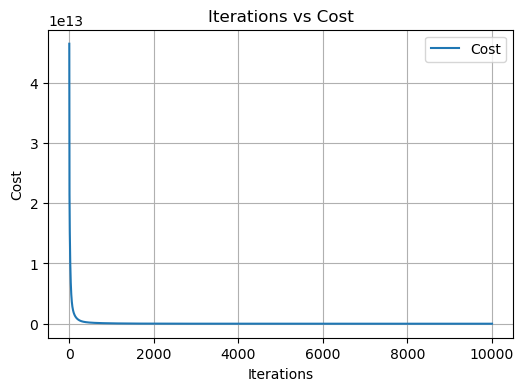

In [29]:
plt.figure(figsize=(6,4))
iterations = np.arange(1, 10001) 
costs = Cost_history_6
plt.plot(iterations, costs, label='Cost')
plt.title('Iterations vs Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

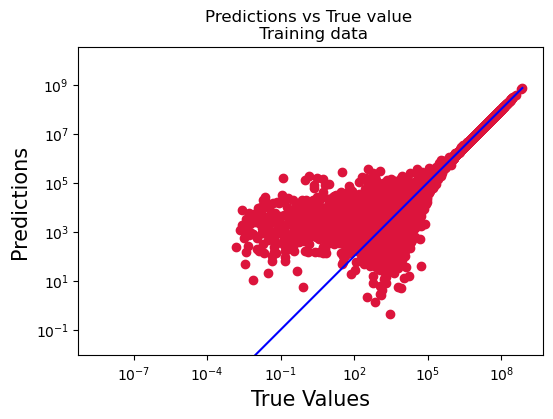

In [30]:
plt.figure(figsize=(6,4))
y_preds
plt.scatter(y_train, y_preds, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_preds), max(y_train))
p2 = min(min(y_preds), min(y_train))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title("Predictions vs True value \n Training data")
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [31]:
y_pred_test = prediction(X_test_6, w_final_6, b_final_6)

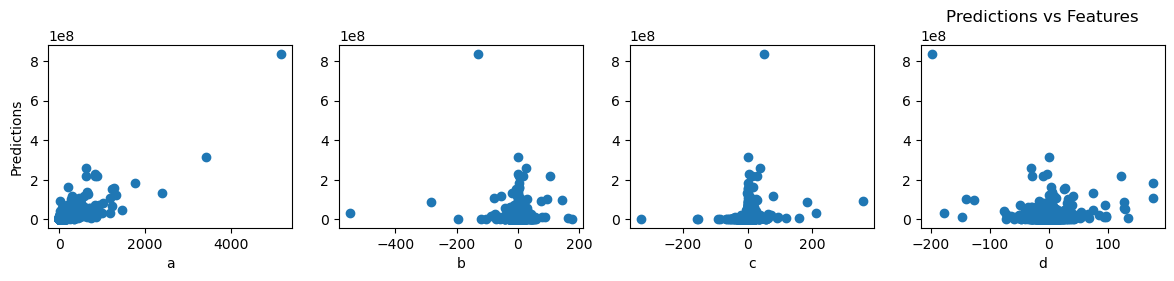

In [32]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
plt.title('Predictions vs Features')
ax[0].scatter(X_test_6[:,0], y_pred_test)
ax[0].set_xlabel('a'); ax[0].set_ylabel('Predictions')
#ax[0].axis('equal')

ax[1].scatter(X_test_6[:,10], y_pred_test)
ax[1].set_xlabel('b'); ax[0].set_ylabel('Predictions')
#ax[1].axis('equal')

ax[2].scatter(X_test_6[:,20], y_pred_test)
ax[2].set_xlabel('c'); ax[0].set_ylabel('Predictions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

ax[3].scatter(X_test_6[:,30], y_pred_test)
ax[3].set_xlabel('d'); ax[0].set_ylabel('Predictions')

plt.show()

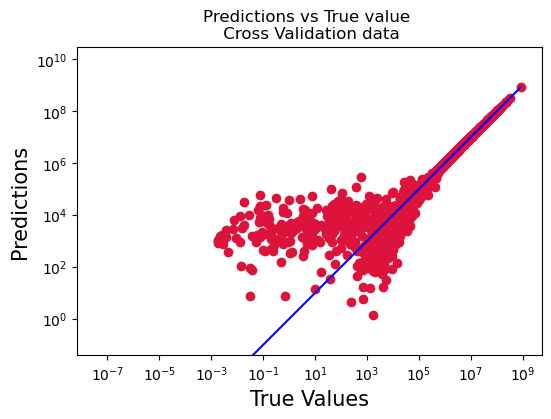

In [43]:
plt.figure(figsize=(6,4))
y_pred_test
plt.scatter(y_test, y_pred_test, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred_test), max(y_test))
p2 = min(min(y_pred_test), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title("Predictions vs True value \n Cross Validation data")
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [34]:
#R2 Score
def R2_score(x, y, w, b):
    y_pred = prediction(x, w, b)
    error = y_pred - y 
    y_mean = np.mean(y)
    y1 = y - y_mean
    rss = np.matmul(np.transpose(error),error)
    tss = np.matmul(np.transpose(y1),y1)
    rss_tss = rss/tss
    r2 = 1 - rss_tss
    return r2

In [35]:
R2_Score_train = R2_score(X_train_6, y_train, w_final_6, b_final_6)
R2_Score_train

0.9999880493606477

In [36]:
R2_score_test = R2_score(X_test_6, y_test, w_final_6, b_final_6)
R2_score_test

0.9999900505068088

Test data

In [37]:
X_test_g6 = np.concatenate([test_data[f'test_degree{6}'], test_data[f'test_degree{5}'], test_data[f'test_degree{4}'] ,test_data[f'test_degree{3}'], test_data[f'test_degree{2}'], test_data[f'test_degree{1}'] ], axis=1)

In [38]:
Y_test = prediction(X_test_g6, w_final_6, b_final_6)

In [39]:
print(Y_test)

[542126.65649533 957034.74989508 -11574.63053745 ... 847361.37266732
  69209.79420998  -3904.90353473]


In [44]:
insert_index = 0
modified_array = np.insert(X_test_g, insert_index, Y_test, axis=1)

In [45]:
df = pd.DataFrame(modified_array)
file_path = 'Polynomial_regression.csv'
df.to_csv(file_path, index=False, header=False)